# Initialization

## Mount to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/VUB/Thesis

/content/drive/My Drive/VUB/Thesis


## Install dependencies

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [4]:
import sys
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.cm import ScalarMappable
import json
import gc
import os

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ['DISPLAY']="0.0"
import cv2
import open3d as o3d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure, mean_squared_error

import OpenEXR
import Imath
from kornia.contrib.extract_patches import extract_tensor_patches, combine_tensor_patches
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

env: PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128


# Constants

In [5]:
DATA_ROOT_DIR_NAME = "./data"

TRAIN_DIR_NAME = DATA_ROOT_DIR_NAME + "/train"
VALID_DIR_NAME = DATA_ROOT_DIR_NAME + "/valid"
TEST_DIR_NAME = DATA_ROOT_DIR_NAME + "/test"

CLEAN_DIR_NAME =  "/clean"
NOISY_DIR_NAME = "/noisy"
INFO_DIR_NAME = "/info"

EXR_REGEX = "/depth_S{:06d}_C{:02d}.exr"
JSON_REGEX = "/info_S{:06d}_C{:02d}.json"

INTRINSIC = "intrinsic"
EXTRINSIC = "extrinsic"

CACHE_DIR_NAME = DATA_ROOT_DIR_NAME + "/cache"
TRAIN_CACHE_CLEAN = CACHE_DIR_NAME + "/train_clean.pickle"
VALID_CACHE_CLEAN = CACHE_DIR_NAME + "/valid_clean.pickle"
TEST_CACHE_CLEAN = CACHE_DIR_NAME + "/test_clean.pickle"
TRAIN_CACHE_NOISY = CACHE_DIR_NAME + "/train_noisy.pickle"
VALID_CACHE_NOISY = CACHE_DIR_NAME + "/valid_noisy.pickle"
TEST_CACHE_NOISY = CACHE_DIR_NAME + "/test_noisy.pickle"

TENSORBOARD = SummaryWriter()

SAVE_MODEL_NAME = 'unet_denoiser_model.pth'
SEGMENTATION_MODEL_NAME = 'segmentation_model.pth'

NO_CAMERAS = 3
NO_SAMPLES = 1500
TRAIN_SAMPLES = int(0.6 * NO_SAMPLES * NO_CAMERAS) // 3
VALID_SAMPLES = int(0.2 * NO_SAMPLES * NO_CAMERAS) // 3
TEST_SAMPLES = int(0.2 * NO_SAMPLES * NO_CAMERAS) // 3

PATCH_SIZE = 64
STRIDE = PATCH_SIZE // 2
PADDING = 0
VALID_PIXELS_PERCENTAGE = 0.7
VALID_PATCH_THRESHOLD = (PATCH_SIZE * PATCH_SIZE) * VALID_PIXELS_PERCENTAGE
BATCH_SIZE = 128

# Data Gathering and Pre-Processing

## Pre-process data

In [6]:
# B = Batch size
# N = number of patches
# C = channels
# H = height
# W = width

def read_depth_image(file_path: str, scene: int, camera_no: int, clean:bool=True):
    # returns a tensor (C x H x W)
    depth_regex = file_path + CLEAN_DIR_NAME + EXR_REGEX if clean else file_path + NOISY_DIR_NAME + EXR_REGEX
    exr_file_name = depth_regex.format(scene, camera_no)
    depth = cv2.imread(exr_file_name, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    return T.ToTensor()(depth)

def extract_samples(file_path: str, dataset: str, clean=True, start_range=None, end_range=None):
    samples = list()
    if start_range is None:
      start_range = 0 if dataset == 'train' else TRAIN_SAMPLES if dataset == 'valid' else TRAIN_SAMPLES + VALID_SAMPLES
    if end_range is None:
      end_range = TRAIN_SAMPLES if dataset == 'train' else TRAIN_SAMPLES + VALID_SAMPLES if dataset == 'valid' else NO_SAMPLES
    for scene in range(start_range, end_range):
        for camera in range(NO_CAMERAS):
            # Read each sample
            # (1024 x 1024) depth map size
            sample = read_depth_image(file_path, scene, camera, clean)
            # Add to final list
            samples.append(sample)
    return samples

def extract_valid_patches(patches):
    # patches = tensor (N x H x W)
    no_patches = patches.shape[0]
    valid_patches = list()
    for idx in range(no_patches):
        patch = patches[idx,:]
        if torch.count_nonzero(patch) > VALID_PATCH_THRESHOLD:
            valid_patches.append(patch)
    return valid_patches

def normalize_patch(patch):
    # patches = tensor (H x W)
    mask = patch > 0  # mask to only consider valid depth values
    valid_idx = torch.nonzero(patch)
    valid_values = patch[valid_idx[:,0], valid_idx[:,1]]
    std, mean = torch.std_mean(valid_values)
    eps = torch.tensor(1e-5)
    scale = torch.max(std, eps)
    patch = torch.where(patch > 0, (patch-mean)/scale, 0)
    return patch, scale

def normalize_patches(patches):
    # patches = tensor (N x H x W)
    normalized_patches = list()
    for patch in patches:
        normalized_patch = normalize_patch(patch)
        normalized_patches.append(normalized_patch)
    return normalized_patches

def extract_patches_from_sample(depth, stride=STRIDE, only_valid=True):
    # depth = tensor (C x H x W)
    # Split the depth map into patches
    depth = depth.unsqueeze(0) # add a dimention for B => (B x C x H x W)
    patches = extract_tensor_patches(depth, PATCH_SIZE, stride, PADDING) # (B x N x C x H x W)
    patches = patches.squeeze(2) # remove channels
    patches = patches.squeeze(0) # remove batch size => (N x H x W)
    if only_valid:
        patches = extract_valid_patches(patches)
    return patches

def extract_patches(samples):
    final_patches = list()
    for sample in tqdm(samples):
        patches = extract_patches_from_sample(sample)
        final_patches.extend(patches)
    return final_patches

def compare_patches(patch, patch_nosisy):
    # Convert the depth map tensor to a NumPy array
    depth_map_np = patch.numpy()
    depth_map_np_n = patch_nosisy.numpy()

    # Display the depth map using Matplotlib
    f, axarr = plt.subplots(1, 2, figsize=(10,10))
    axarr[0].imshow(depth_map_np, cmap='inferno')
    axarr[1].imshow(depth_map_np_n, cmap='inferno')
    scales = np.linspace(0, 1, 2)
    cmap = plt.get_cmap("inferno")
    norm = plt.Normalize(scales.min(), scales.max())
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = f.colorbar(sm, ax=axarr)
    cbar.ax.set_title("scale")    

def compare_patches_3(patch1, patch2, patch3):
    # Convert the depth map tensor to a NumPy array
    patch1_np = patch1.numpy()
    patch2_np = patch2.numpy()
    patch3_np = patch3.numpy()

    # Display the depth map using Matplotlib
    f, axarr = plt.subplots(1, 3, figsize=(10,10))
    axarr[0].imshow(patch1_np, cmap='inferno')
    axarr[0].set_title('Clean')
    axarr[1].imshow(patch2_np, cmap='inferno')
    axarr[1].set_title('Predicted')
    axarr[2].imshow(patch3_np, cmap='inferno')
    axarr[2].set_title('Noisy')

## Define dataset

In [ ]:
class DepthMapDataset(Dataset):
    def __init__(self, file_path, dataset, start, end, use_cache):
        self.clean_data = self.extract_data(file_path, dataset, True, start, end, use_cache)
        self.noisy_data = self.extract_data(file_path, dataset, False, start, end, use_cache)
    
    def extract_data(self, file_path, dataset, clean:bool, start=None, end=None, use_cache=True):
        clean_noisy = 'clean' if clean else 'noisy'
        if use_cache:
            data = self.get_cached_files(dataset, clean)
            if data is not None:
                print(f"Found cached files for {clean_noisy} {dataset} dataset with {len(data)} elements.")
                return data
        samples = extract_samples(file_path, dataset, clean, start, end)
        patches = extract_patches(samples)
        if use_cache:
            self.cache_files(dataset, patches, clean)
            print(f"Cached files for {clean_noisy} {dataset} dataset with {len(patches)} elements.")
        else:
            print(f"Created files for {clean_noisy} {dataset} dataset with {len(patches)} elements.")
        return patches

    def cache_files(self, dataset, data, clean):
        if dataset == 'train':
            if clean:
                torch.save(data, TRAIN_CACHE_CLEAN)
            else:
                torch.save(data, TRAIN_CACHE_NOISY)
        elif dataset == 'valid':
            if clean:
                torch.save(data, VALID_CACHE_CLEAN)
            else:
                torch.save(data, VALID_CACHE_NOISY)
        elif dataset == 'test':
            if clean:
                torch.save(data, TEST_CACHE_CLEAN)
            else:
                torch.save(data, TEST_CACHE_NOISY)

    def get_cached_files(self, dataset, clean):
        data = None
        if dataset == 'train' and clean:
            data = torch.load(TRAIN_CACHE_CLEAN) if os.path.exists(TRAIN_CACHE_CLEAN) else None
        elif dataset == 'train' and not clean:
            data = torch.load(TRAIN_CACHE_NOISY) if os.path.exists(TRAIN_CACHE_NOISY) else None
        elif dataset == 'valid' and clean:
            data = torch.load(VALID_CACHE_CLEAN) if os.path.exists(VALID_CACHE_CLEAN) else None
        elif dataset == 'valid' and not clean:
            data = torch.load(VALID_CACHE_NOISY) if os.path.exists(VALID_CACHE_NOISY) else None
        elif dataset == 'test' and clean:
            data = torch.load(TEST_CACHE_CLEAN) if os.path.exists(TEST_CACHE_CLEAN) else None
        elif dataset == 'test' and not clean:
            data = torch.load(TEST_CACHE_NOISY) if os.path.exists(TEST_CACHE_NOISY) else None
        return data
        
    def __len__(self):
        return len(self.clean_data)
    
    def __getitem__(self, index):
        clean_patch = self.clean_data[index]
        noisy_patch = self.noisy_data[index]
        return clean_patch, noisy_patch

In [ ]:
def get_loader(file_path=TRAIN_DIR_NAME, dataset='train', start=0, end=100, use_cache=True, batch_size=32, num_workers=4, shuffle=False, pin_memory=True):
    dataset = DepthMapDataset(file_path, dataset, start, end, use_cache)
    loader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle, 
        pin_memory=pin_memory)
    
    return loader, dataset

In [ ]:
train_loader, train_dataset = get_loader(file_path=TRAIN_DIR_NAME,
                                         dataset='train',
                                         start=0,
                                         end=200,
                                         use_cache=True,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)
valid_loader, valid_dataset = get_loader(file_path=VALID_DIR_NAME,
                                         dataset='valid',
                                         start=900,
                                         end=950,
                                         use_cache=True,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)
test_loader, test_dataset = get_loader(file_path=TEST_DIR_NAME,
                                       dataset='test',
                                       start=1200,
                                       end=1210,
                                       use_cache=True,
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False)

Found cached files for clean train dataset with 76948 elements.
Found cached files for noisy train dataset with 76948 elements.
Found cached files for clean valid dataset with 19543 elements.
Found cached files for noisy valid dataset with 19543 elements.
Found cached files for clean test dataset with 4034 elements.
Found cached files for noisy test dataset with 4034 elements.


### Display a patch

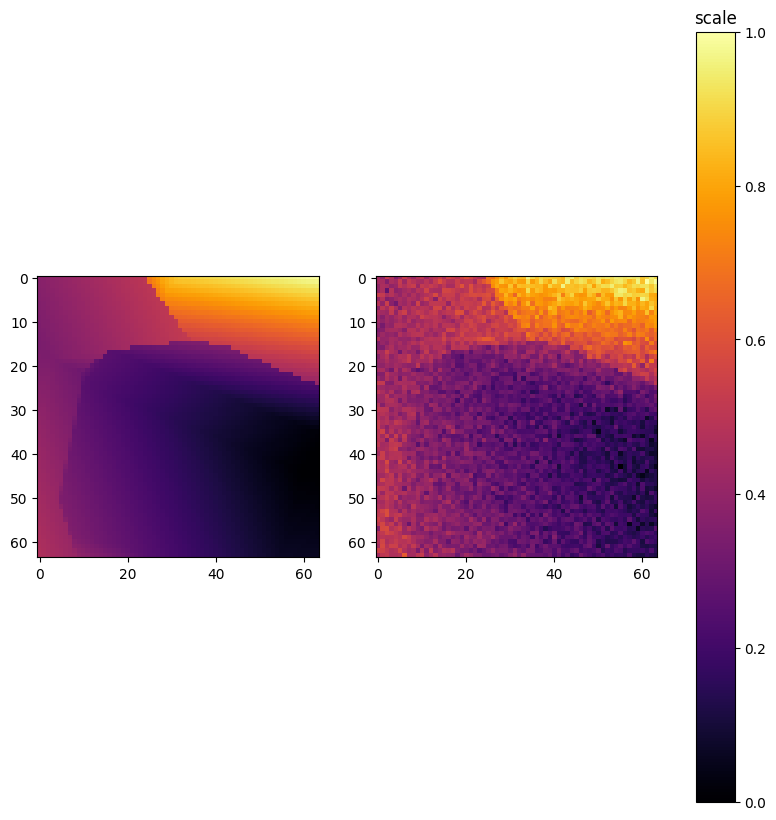

In [ ]:
# Extract a clean & a noisy patch
RANDOM_SAMPLE_ID = 21
depth_map = test_dataset.clean_data[RANDOM_SAMPLE_ID]
depth_map_n = test_dataset.noisy_data[RANDOM_SAMPLE_ID]

compare_patches(depth_map, depth_map_n)

# Model

## Hyperparameters

In [ ]:
LEARNING_RATE = 8e-4
EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Architecture

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNetDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(UNetDenoisingAutoencoder, self).__init__()
        self.channels = 1
        
        # Down-sampling layers
        self.conv1 = DoubleConv(self.channels, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv2 = DoubleConv(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv3 = DoubleConv(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv4 = DoubleConv(64, 128, kernel_size=3)

        # Up-sampling layers
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=29)
        self.conv5 = DoubleConv(128, 64, kernel_size=3)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=30)
        self.conv6 = DoubleConv(64, 32, kernel_size=3)
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=31)
        self.conv7 = DoubleConv(32, 16, kernel_size=3)

        # Output layer
        self.out = nn.Conv2d(16, self.channels, kernel_size=1)

    def forward(self, x):
        # Down-sampling
        x1 = self.conv1(x)
        x = self.pool1(x1)
        x2 = self.conv2(x)
        x = self.pool2(x2)
        x3 = self.conv3(x)
        x = self.pool3(x3)
        x4 = self.conv4(x)

        # Up-sampling
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv5(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv6(x)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv7(x)

        # Output
        x = self.out(x)
        return x

# Training

In [ ]:
def mse_loss(criterion, output, clean_patch):
    mask = clean_patch > 0  # mask to only consider valid depth values
    loss = criterion(output, clean_patch)
    loss = (loss * mask.float()).sum()
    non_zero_elements = mask.sum()
    mse_loss_val = loss / non_zero_elements
    return mse_loss_val

In [ ]:
def mse(image_pred, image_gt):
    mask = image_gt > 0
    value = (image_pred-image_gt)**2
    value = value[mask]
    return torch.mean(value)

In [ ]:
def psnr(image_pred, image_gt, mse):
    mask = image_gt > 0
    return -10*torch.log10(mse)

### Load segmentation model

In [ ]:
class SegmentationAutoencoder(nn.Module):
    def __init__(self, input_channels):
        super(SegmentationAutoencoder, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Output layer
        self.out = nn.Conv2d(16, input_channels, kernel_size=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))

        out = self.out(x)
        return out

In [ ]:
segmentation_model = SegmentationAutoencoder(1).to('cpu')
segmentation_model.load_state_dict(torch.load(SEGMENTATION_MODEL_NAME))

<All keys matched successfully>

In [ ]:
class SegmentedDataset(Dataset):
    def __init__(self, dataset: DepthMapDataset):
        self.clean_data_segmented, self.noisy_data_segmented = self.segment_data(dataset.clean_data, dataset.noisy_data)
    
    def segment_data(self, clean_data, noisy_data):
        segmented_clean_patches = list()
        segmented_noisy_patches = list()
        for idx in range(len(clean_data)):
            clean_patch = clean_data[idx] # 64 x 64
            noisy_patch = noisy_data[idx]
            clean_patch_processed = clean_patch.unsqueeze(0).unsqueeze(0) # 1 x 1 x 64 x 64
            segmentation_mask = segmentation_model(clean_patch_processed) > 0
            segmentation_mask = segmentation_mask.squeeze(0).squeeze(0) # 64 x 64
            # Process clean
            clean_patch_extracted = clean_patch * segmentation_mask
            clean_patch_remainder = clean_patch * (~segmentation_mask)
            segmented_clean_patches.append(clean_patch_extracted)
            segmented_clean_patches.append(clean_patch_remainder)
            # Process noisy
            noisy_patch_extracted = noisy_patch * segmentation_mask
            noisy_patch_remainder = noisy_patch * (~segmentation_mask)
            segmented_noisy_patches.append(noisy_patch_extracted)
            segmented_noisy_patches.append(noisy_patch_remainder)
        return segmented_clean_patches, segmented_noisy_patches
        
    def __len__(self):
        return len(self.clean_data_segmented)
    
    def __getitem__(self, index):
        clean_patch = self.clean_data_segmented[index]
        noisy_patch = self.noisy_data_segmented[index]
        return clean_patch, noisy_patch

In [ ]:
def get_loader_segmented(init_dataset, batch_size=32, num_workers=4, shuffle=False, pin_memory=True):
    dataset = SegmentedDataset(init_dataset)
    loader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle, 
        pin_memory=pin_memory)
    
    return loader, dataset

In [ ]:
train_loader_segmented, train_dataset_segmented = get_loader_segmented(init_dataset=train_dataset,
                                                                       batch_size=BATCH_SIZE, 
                                                                       shuffle=True)
valid_loader_segmented, valid_dataset_segmented = get_loader_segmented(init_dataset=valid_dataset,
                                                                       batch_size=BATCH_SIZE,
                                                                       shuffle=True)
test_loader_segmented, test_dataset_segmented = get_loader_segmented(init_dataset=test_dataset,
                                                                     batch_size=BATCH_SIZE, 
                                                                     shuffle=False)

In [ ]:
print(len(train_dataset_segmented))
print(len(valid_dataset_segmented))
print(len(test_dataset_segmented))

153896
39086
8068


In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

# Define the denoising autoencoder model and optimizer
model = UNetDenoisingAutoencoder().to(device)
print("Running on device ", device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
criterion = nn.MSELoss(reduction='none')

# Train the denoising autoencoder
for epoch in range(EPOCHS):
    # Training
    train_loss = 0.0
    train_psnr = torch.tensor(0.0)
    train_ssim = torch.tensor(0.0)
    model.train()
    for idx, data in enumerate(tqdm(train_loader_segmented)):
        clean_patch, noisy_patch = data

        # Send data to cuda
        if torch.cuda.is_available():
            clean_patch, noisy_patch = clean_patch.cuda(), noisy_patch.cuda()

        # Normalize pathces
        normalized_noisy_patch, scale = normalize_patch(noisy_patch)
        normalized_noisy_patch = normalized_noisy_patch.unsqueeze(1)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(normalized_noisy_patch)

        # De-normalize
        output = output.squeeze(1)
        output = torch.mul(output, scale)

        # Subtract the noise
        output = torch.subtract(noisy_patch, output)
        
        # Compute the loss
        loss = mse_loss(criterion, output, clean_patch)
        mse_val = loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()
        train_psnr = train_psnr + psnr(output, clean_patch, mse_val)
        train_ssim = train_ssim + structural_similarity_index_measure(output.unsqueeze(1), clean_patch.unsqueeze(1))
        if idx >= len(train_loader_segmented) // 2: break

    # Validation
    gc.collect()
    torch.cuda.empty_cache() 
    valid_loss = 0.0
    valid_psnr = torch.tensor(0.0)
    valid_ssim = torch.tensor(0.0)
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(tqdm(valid_loader_segmented)):
            clean_patch, noisy_patch = data

            # Send data to cuda
            if torch.cuda.is_available():
                clean_patch, noisy_patch = clean_patch.cuda(), noisy_patch.cuda()

            # Normalize pathces
            normalized_noisy_patch, scale = normalize_patch(noisy_patch)
            normalized_noisy_patch = normalized_noisy_patch.unsqueeze(1)
        
            # Forward pass
            output = model(normalized_noisy_patch)

            # De-normalize
            output = output.squeeze(1)
            output = torch.mul(output, scale)

            # Subtract the noise
            output = torch.subtract(noisy_patch, output)
        
            # Compute the loss
            loss = mse_loss(criterion, output, clean_patch)
            mse_val = loss

            valid_loss = valid_loss + loss.item()
            valid_psnr = valid_psnr + psnr(output, clean_patch, mse_val)
            valid_ssim = valid_ssim + structural_similarity_index_measure(output.unsqueeze(1), clean_patch.unsqueeze(1))
            if idx >= len(valid_loader_segmented) // 2: break
        
    train_loss = train_loss / (len(train_loader_segmented) // 2) * 1000
    valid_loss = valid_loss / (len(valid_loader_segmented) // 2) * 1000
    train_psnr = train_psnr / (len(train_loader_segmented) // 2)
    valid_psnr = valid_psnr / (len(valid_loader_segmented) // 2)
    train_ssim = train_ssim / (len(train_loader_segmented) // 2)
    valid_ssim = valid_ssim / (len(valid_loader_segmented) // 2)
    TENSORBOARD.add_scalar("Train loss", train_loss, epoch)
    TENSORBOARD.add_scalar("Valid loss", valid_loss, epoch)
    TENSORBOARD.add_scalar("Train PSNR", train_psnr, epoch)
    TENSORBOARD.add_scalar("Valid PSNR", valid_psnr, epoch)
    TENSORBOARD.add_scalar("Train SSIM", train_ssim, epoch)
    TENSORBOARD.add_scalar("Valid SSIM", valid_ssim, epoch)
    print(f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    print(f"                            Train PSNR: {train_psnr:.4f}, Valid PSNR: {valid_psnr:.4f}")
    print(f"                            Train SSIM: {train_ssim:.4f}, Valid SSIM: {valid_ssim:.4f}")
TENSORBOARD.flush()
TENSORBOARD.close()

Running on device  cuda:0


 50%|█████     | 153/306 [00:05<00:05, 26.85it/s]


Epoch [1/10]: Train Loss: 0.1558, Valid Loss: 0.0322
                            Train PSNR: 41.2786, Valid PSNR: 45.2471
                            Train SSIM: 0.9816, Valid SSIM: 1.0051


 50%|█████     | 153/306 [00:05<00:05, 27.09it/s]


Epoch [2/10]: Train Loss: 0.0284, Valid Loss: 0.0230
                            Train PSNR: 45.6156, Valid PSNR: 46.7294
                            Train SSIM: 0.9998, Valid SSIM: 1.0058


 50%|█████     | 153/306 [00:05<00:05, 27.41it/s]


Epoch [3/10]: Train Loss: 0.0217, Valid Loss: 0.0189
                            Train PSNR: 46.7357, Valid PSNR: 47.5818
                            Train SSIM: 1.0006, Valid SSIM: 1.0059


 50%|█████     | 153/306 [00:05<00:05, 27.11it/s]


Epoch [4/10]: Train Loss: 0.0182, Valid Loss: 0.0167
                            Train PSNR: 47.4955, Valid PSNR: 48.1191
                            Train SSIM: 1.0007, Valid SSIM: 1.0059


 50%|█████     | 153/306 [00:05<00:05, 27.43it/s]


Epoch [5/10]: Train Loss: 0.0170, Valid Loss: 0.0160
                            Train PSNR: 47.8535, Valid PSNR: 48.3070
                            Train SSIM: 1.0005, Valid SSIM: 1.0052


 50%|█████     | 153/306 [00:05<00:05, 26.86it/s]


Epoch [6/10]: Train Loss: 0.0153, Valid Loss: 0.0144
                            Train PSNR: 48.2715, Valid PSNR: 48.7613
                            Train SSIM: 1.0009, Valid SSIM: 1.0061


 50%|█████     | 153/306 [00:05<00:05, 27.69it/s]


Epoch [7/10]: Train Loss: 0.0145, Valid Loss: 0.0140
                            Train PSNR: 48.4933, Valid PSNR: 48.9064
                            Train SSIM: 1.0009, Valid SSIM: 1.0057


 50%|█████     | 153/306 [00:05<00:05, 27.39it/s]


Epoch [8/10]: Train Loss: 0.0137, Valid Loss: 0.0129
                            Train PSNR: 48.7352, Valid PSNR: 49.2472
                            Train SSIM: 1.0010, Valid SSIM: 1.0061


 50%|█████     | 153/306 [00:05<00:05, 27.37it/s]


Epoch [9/10]: Train Loss: 0.0130, Valid Loss: 0.0129
                            Train PSNR: 48.9823, Valid PSNR: 49.2634
                            Train SSIM: 1.0011, Valid SSIM: 1.0055


 50%|█████     | 153/306 [00:05<00:05, 27.12it/s]

Epoch [10/10]: Train Loss: 0.0125, Valid Loss: 0.0119
                            Train PSNR: 49.1479, Valid PSNR: 49.5962
                            Train SSIM: 1.0010, Valid SSIM: 1.0062


## Train on second part

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Train the denoising autoencoder
for epoch in range(EPOCHS):
    # Training
    train_loss = 0.0
    train_psnr = torch.tensor(0.0)
    train_ssim = torch.tensor(0.0)
    model.train()
    for idx, data in enumerate(tqdm(train_loader_segmented), start=(len(train_loader_segmented) // 2)):
        clean_patch, noisy_patch = data

        # Send data to cuda
        if torch.cuda.is_available():
            clean_patch, noisy_patch = clean_patch.cuda(), noisy_patch.cuda()

        # Normalize pathces
        normalized_noisy_patch, scale = normalize_patch(noisy_patch)
        normalized_noisy_patch = normalized_noisy_patch.unsqueeze(1)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(normalized_noisy_patch)

        # De-normalize
        output = output.squeeze(1)
        output = torch.mul(output, scale)

        # Subtract the noise
        output = torch.subtract(noisy_patch, output)
        
        # Compute the loss
        loss = mse_loss(criterion, output, clean_patch)
        mse_val = loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()
        train_psnr = train_psnr + psnr(output, clean_patch, mse_val)
        train_ssim = train_ssim + structural_similarity_index_measure(output.unsqueeze(1), clean_patch.unsqueeze(1))
        if idx == len(train_loader_segmented): break

    # Validation
    gc.collect()
    torch.cuda.empty_cache() 
    valid_loss = 0.0
    valid_psnr = torch.tensor(0.0)
    valid_ssim = torch.tensor(0.0)
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(tqdm(valid_loader_segmented), start=(len(valid_loader_segmented) // 2)):
            clean_patch, noisy_patch = data

            # Send data to cuda
            if torch.cuda.is_available():
                clean_patch, noisy_patch = clean_patch.cuda(), noisy_patch.cuda()

            # Normalize pathces
            normalized_noisy_patch, scale = normalize_patch(noisy_patch)
            normalized_noisy_patch = normalized_noisy_patch.unsqueeze(1)
        
            # Forward pass
            output = model(normalized_noisy_patch)

            # De-normalize
            output = output.squeeze(1)
            output = torch.mul(output, scale)

            # Subtract the noise
            output = torch.subtract(noisy_patch, output)
        
            # Compute the loss
            loss = mse_loss(criterion, output, clean_patch)
            mse_val = loss

            valid_loss = valid_loss + loss.item()
            valid_psnr = valid_psnr + psnr(output, clean_patch, mse_val)
            valid_ssim = valid_ssim + structural_similarity_index_measure(output.unsqueeze(1), clean_patch.unsqueeze(1))
            if idx == len(valid_loader_segmented): break
        
    train_loss = train_loss / (len(train_loader_segmented) // 2) * 1000
    valid_loss = valid_loss / (len(valid_loader_segmented) // 2) * 1000
    train_psnr = train_psnr / (len(train_loader_segmented) // 2)
    valid_psnr = valid_psnr / (len(valid_loader_segmented) // 2)
    train_ssim = train_ssim / (len(train_loader_segmented) // 2)
    valid_ssim = valid_ssim / (len(valid_loader_segmented) // 2)
    TENSORBOARD.add_scalar("Train loss", train_loss, epoch)
    TENSORBOARD.add_scalar("Valid loss", valid_loss, epoch)
    TENSORBOARD.add_scalar("Train PSNR", train_psnr, epoch)
    TENSORBOARD.add_scalar("Valid PSNR", valid_psnr, epoch)
    TENSORBOARD.add_scalar("Train SSIM", train_ssim, epoch)
    TENSORBOARD.add_scalar("Valid SSIM", valid_ssim, epoch)
    print(f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    print(f"                            Train PSNR: {train_psnr:.4f}, Valid PSNR: {valid_psnr:.4f}")
    print(f"                            Train SSIM: {train_ssim:.4f}, Valid SSIM: {valid_ssim:.4f}")
TENSORBOARD.flush()
TENSORBOARD.close()

 50%|█████     | 153/306 [00:05<00:05, 27.16it/s]


Epoch [1/10]: Train Loss: 0.0112, Valid Loss: 0.0108
                            Train PSNR: 49.6932, Valid PSNR: 50.0263
                            Train SSIM: 1.0028, Valid SSIM: 1.0062


 50%|█████     | 153/306 [00:05<00:05, 27.23it/s]


Epoch [2/10]: Train Loss: 0.0108, Valid Loss: 0.0106
                            Train PSNR: 49.8516, Valid PSNR: 50.1195
                            Train SSIM: 1.0028, Valid SSIM: 1.0062


 50%|█████     | 153/306 [00:05<00:05, 27.03it/s]


Epoch [3/10]: Train Loss: 0.0103, Valid Loss: 0.0102
                            Train PSNR: 50.0720, Valid PSNR: 50.3027
                            Train SSIM: 1.0029, Valid SSIM: 1.0062


 50%|█████     | 153/306 [00:05<00:05, 26.94it/s]


Epoch [4/10]: Train Loss: 0.0101, Valid Loss: 0.0104
                            Train PSNR: 50.1654, Valid PSNR: 50.1998
                            Train SSIM: 1.0028, Valid SSIM: 1.0057


 50%|█████     | 153/306 [00:05<00:05, 26.72it/s]


Epoch [5/10]: Train Loss: 0.0098, Valid Loss: 0.0095
                            Train PSNR: 50.2690, Valid PSNR: 50.5782
                            Train SSIM: 1.0028, Valid SSIM: 1.0061


 50%|█████     | 153/306 [00:05<00:05, 27.12it/s]


Epoch [6/10]: Train Loss: 0.0095, Valid Loss: 0.0093
                            Train PSNR: 50.4036, Valid PSNR: 50.7024
                            Train SSIM: 1.0029, Valid SSIM: 1.0062


 50%|█████     | 153/306 [00:05<00:05, 27.00it/s]


Epoch [7/10]: Train Loss: 0.0093, Valid Loss: 0.0094
                            Train PSNR: 50.4908, Valid PSNR: 50.6295
                            Train SSIM: 1.0029, Valid SSIM: 1.0060


 50%|█████     | 153/306 [00:05<00:05, 26.65it/s]


Epoch [8/10]: Train Loss: 0.0092, Valid Loss: 0.0091
                            Train PSNR: 50.5417, Valid PSNR: 50.7566
                            Train SSIM: 1.0029, Valid SSIM: 1.0059


 50%|█████     | 153/306 [00:05<00:05, 27.14it/s]


Epoch [9/10]: Train Loss: 0.0090, Valid Loss: 0.0094
                            Train PSNR: 50.6413, Valid PSNR: 50.6340
                            Train SSIM: 1.0029, Valid SSIM: 1.0059


 50%|█████     | 153/306 [00:05<00:05, 27.03it/s]

Epoch [10/10]: Train Loss: 0.0088, Valid Loss: 0.0088
                            Train PSNR: 50.7586, Valid PSNR: 50.9517
                            Train SSIM: 1.0030, Valid SSIM: 1.0062


# Visualize loss

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# Evaluation

  3%|▎         | 1/32 [00:02<01:13,  2.38s/it]

Batch 0: MSE: 0.0097, PSNR (only valid pixels): 20.1480, PNSR (all pixels): 56.6104, SSIM: 0.9998


 34%|███▍      | 11/32 [00:04<00:05,  3.73it/s]

Batch 10: MSE: 0.0125, PSNR (only valid pixels): 19.0450, PNSR (all pixels): 54.5487, SSIM: 0.9996


 66%|██████▌   | 21/32 [00:07<00:02,  3.93it/s]

Batch 20: MSE: 0.0097, PSNR (only valid pixels): 20.1175, PNSR (all pixels): 57.7709, SSIM: 0.9999


100%|██████████| 32/32 [00:09<00:00,  4.64it/s]

Batch 30: MSE: 0.0097, PSNR (only valid pixels): 20.1351, PNSR (all pixels): 56.0775, SSIM: 0.9998


100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


MSE: 0.0112, PSNR (only valid pixels): 19.8194, PNSR (all pixels): 56.2934, SSIM: 0.9995


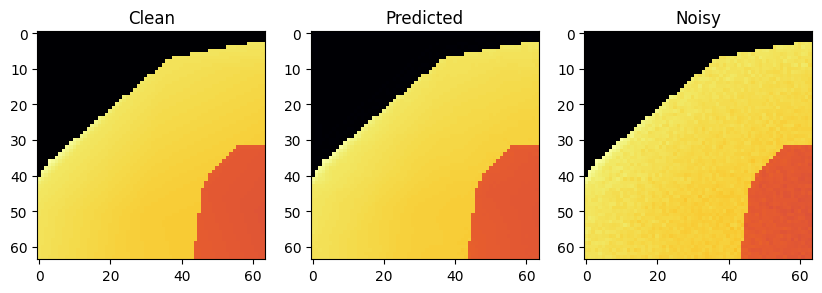

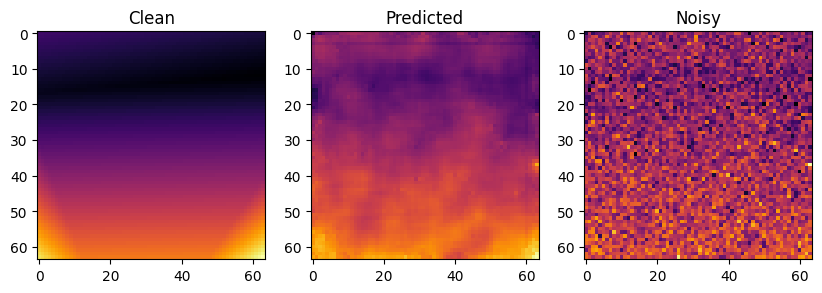

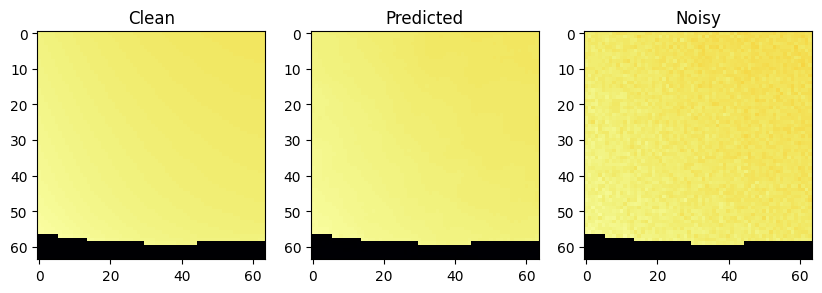

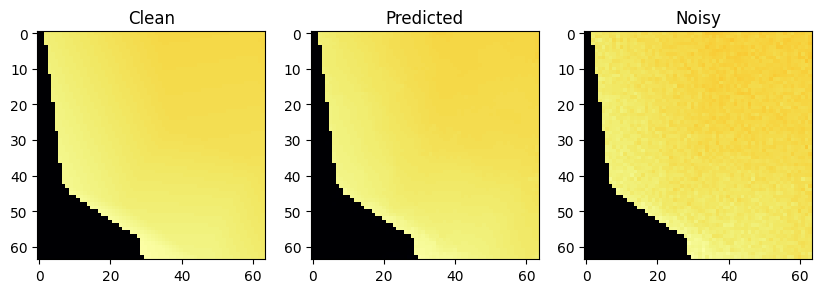

In [ ]:
torch.cuda.empty_cache()
model.eval()

mse_test = 0.0
psnr_test = 0.0
psnr_all_test = 0.0
ssim_test = 0.0
for idx, data in enumerate(tqdm(test_loader)):
    clean_patch, noisy_patch = data

    # Send data to cuda
    if torch.cuda.is_available():
        clean_patch_dev, noisy_patch_dev = clean_patch.cuda(), noisy_patch.cuda()

    # Normalize pathces
    normalized_noisy_patch, scale = normalize_patch(noisy_patch_dev)
    normalized_noisy_patch = normalized_noisy_patch.unsqueeze(1)
        
    # Forward pass
    output = model(normalized_noisy_patch)

    # De-normalize
    output = output.squeeze(1)
    output = torch.mul(output, scale)

    # Subtract the noise
    output = torch.subtract(noisy_patch_dev, output)
    pred = output.squeeze(0).detach().cpu()

    mse_val = mse(pred, clean_patch) * 1000
    psnr_val = psnr(pred, clean_patch, mse_val)
    psnr_all = peak_signal_noise_ratio(pred, clean_patch)
    ssim = structural_similarity_index_measure(pred.unsqueeze(0).unsqueeze(0), clean_patch.unsqueeze(0).unsqueeze(0))

    mse_test = mse_test + mse_val
    psnr_test = psnr_test + psnr_val
    psnr_all_test = psnr_all_test + psnr_all
    ssim_test = ssim_test + ssim

    if idx % 10 == 0:
        print(f"Batch {idx}: MSE: {mse_val:.4f}, PSNR (only valid pixels): {psnr_val:.4f}, PNSR (all pixels): {psnr_all:.4f}, SSIM: {ssim:.4f}")
        compare_patches_3(clean_patch[0], pred[0], noisy_patch[0])

mse_test = mse_test / len(test_loader)
psnr_test = psnr_test / len(test_loader)
psnr_all_test = psnr_all_test / len(test_loader)
ssim_test = ssim_test / len(test_loader)
print(f"MSE: {mse_test:.4f}, PSNR (only valid pixels): {psnr_test:.4f}, PNSR (all pixels): {psnr_all_test:.4f}, SSIM: {ssim_test:.4f}")

### Test a whole image

In [8]:
def print_depth_map(depth):
    depth_np = depth.numpy()
    plt.imshow(depth_np, cmap="inferno")
    plt.colorbar()
    plt.show()

def patches_to_image(x, grid_size=(2, 2)):
    # x shape is batch_size x num_patches x c x jigsaw_h x jigsaw_w
    batch_size, num_patches, c, jigsaw_h, jigsaw_w = x.size()
    assert num_patches == grid_size[0] * grid_size[1]
    x_image = x.view(batch_size, grid_size[0], grid_size[1], c, jigsaw_h, jigsaw_w)
    output_h = grid_size[0] * jigsaw_h
    output_w = grid_size[1] * jigsaw_w
    x_image = x_image.permute(0, 3, 1, 4, 2, 5).contiguous()
    x_image = x_image.view(batch_size, c, output_h, output_w)
    return x_image

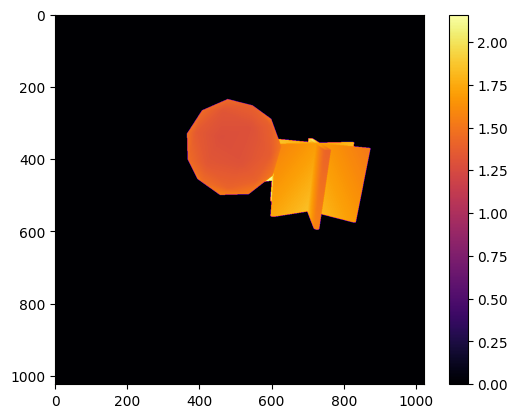

In [10]:
depth = read_depth_image(TEST_DIR_NAME, 1201, 0, True)
print_depth_map(depth.squeeze(0))

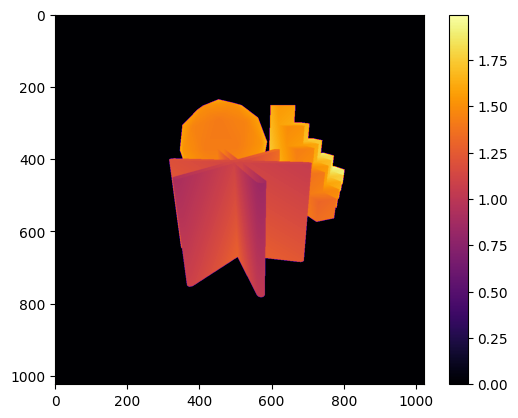

In [11]:
depth = read_depth_image(TEST_DIR_NAME, 1201, 1, True)
print_depth_map(depth.squeeze(0))

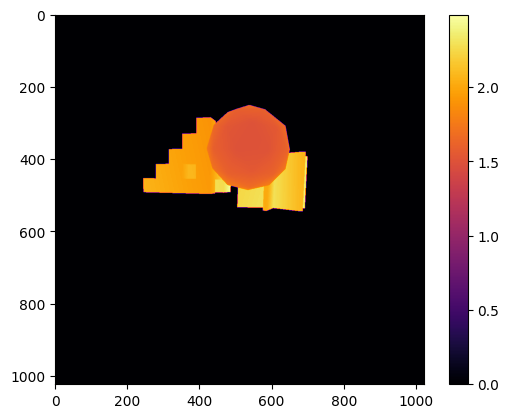

In [12]:
depth = read_depth_image(TEST_DIR_NAME, 1201, 2, True)
print_depth_map(depth.squeeze(0))

In [ ]:
gc.collect()
torch.cuda.empty_cache()

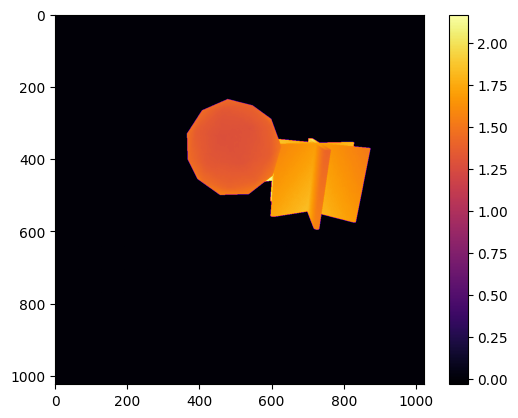

In [ ]:
model_cpu = model.to("cpu")

# Split into patches
patches = extract_patches_from_sample(depth, stride=PATCH_SIZE, only_valid=False)
noisy_patch_ex = patches[121]

# Add channel
patches = patches.unsqueeze(1)

# Batch data
batched_paches = DataLoader(patches, batch_size = BATCH_SIZE)

first_half = torch.tensor(0)
second_half = torch.tensor(0)

# Denoise
for idx, data in enumerate(batched_paches):
    
    # Normalize pathces
    normalized_noisy_patch, scale = normalize_patch(data)
        
    # Forward pass
    output = model_cpu(normalized_noisy_patch)

    # De-normalize
    output = torch.mul(output, scale)

    # Subtract the noise
    output = torch.subtract(data, output)

    if idx == 0:
        first_half = output
    else:
        second_half = output

# Put patches back together
combined_picture = torch.cat((first_half, second_half), 0)
denoised_patch_ex = combined_picture.squeeze(1)[121]
denoised_img = patches_to_image(combined_picture.unsqueeze(0), (16,16))
denoised_img = denoised_img.squeeze(0).squeeze(0).detach()
print_depth_map(denoised_img)

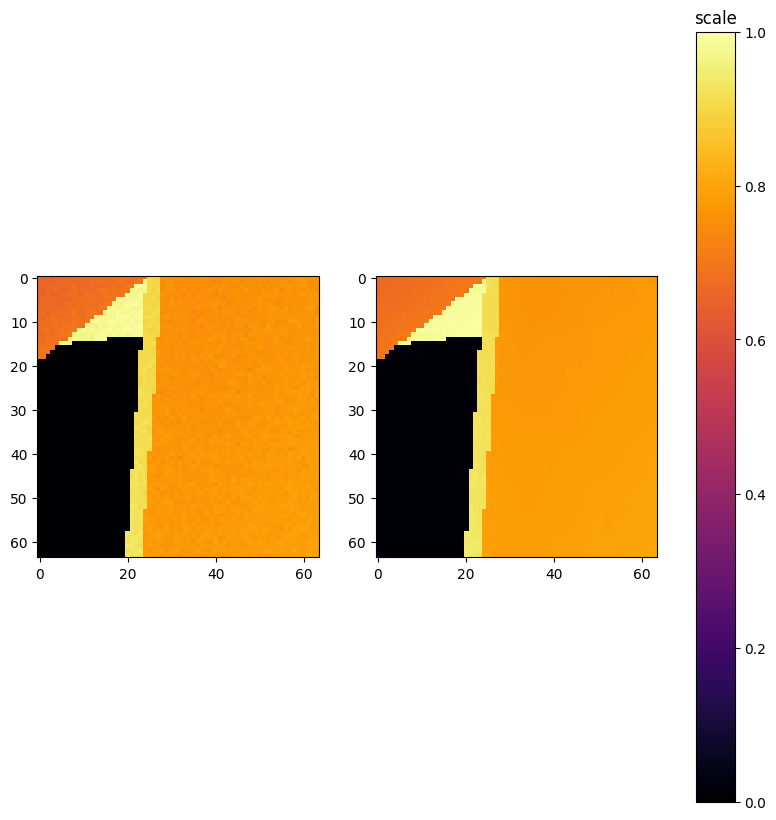

In [ ]:
compare_patches(noisy_patch_ex, denoised_patch_ex.detach())

# Save model

In [ ]:
# torch.save(model.state_dict(), SAVE_MODEL_NAME)

# Load pre-trained model

In [ ]:
# pretrained_model = UNetDenoisingAutoencoder().to(device)
# pretrained_model.load_state_dict(torch.load(SAVE_MODEL_NAME, map_location=torch.device('cpu'))['state_dict'])